<a href="https://colab.research.google.com/github/devgokulbv/SPIKING-NEURAL-NETWORKS-APPLICATIONS/blob/main/Next_Frame_Prediction_SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_regression_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# Regression with SNNs: Part I
## Learning Membrane Potentials with LIF Neurons
## By Alexander Henkes (https://orcid.org/0000-0003-4615-9271) and Jason K. Eshraghian (www.ncg.ucsc.edu)


<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_regression_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


This tutorial is based on the following papers on nonlinear regression and spiking neural networks. If you find these resources or code useful in your work, please consider citing the following sources:

> <cite> [Alexander Henkes, Jason K. Eshraghian, and Henning Wessels. “Spiking neural networks for nonlinear regression", arXiv preprint arXiv:2210.03515, October 2022.](https://arxiv.org/abs/2210.03515) </cite>

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

In the regression tutorial series, you will learn how to use snnTorch to perform regression using a variety of spiking neuron models, including:

* Leaky Integrate-and-Fire (LIF) Neurons
* Recurrent LIF Neurons
* Spiking LSTMs

An overview of the regression tutorial series:

* Part I (this tutorial) will train the membrane potential of a LIF neuron to follow a given trajectory over time.
* Part II will use LIF neurons with recurrent feedback to perform classification using regression-based loss functions
* Part III will use a more complex spiking LSTM network instead to train the firing time of a neuron.


If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch and Tonic by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install snntorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.9 MB/s eta 0:00:00


In [2]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

Fix the random seed:

In [3]:
# Seed
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# 1. Spiking Regression
## 1.1 A Quick Background on Linear and Nonlinear Regression

The tutorials so far have focused on multi-class classification problems. But if you've made it this far, then it's probably safe to say that your brain can do more than distinguish cats and dogs. You're amazing and we believe in you.

An alternative problem is regression, where multiple input features $x_i$ are used to estimate an output on a continuous number line $y \in \mathbb{R}$.
A classic example is estimating the price of a house, given a bunch of inputs such as land size, number of rooms, and the local demand for avocado toast.

The objective of a regression problem is often the mean-square error:

$$\mathcal{L}_{MSE} = \frac{1}{n}\sum_{i=1}^n(y_i-\hat{y_i})^2$$

or the mean absolute error:

$$\mathcal{L}_{L1} = \frac{1}{n}\sum_{i=1}^n|y_i-\hat{y_i}|$$


where $y$ is the target and $\hat{y}$ is the predicted value.

One of the challenges of linear regression is that it can only use linear weightings of input features in predicting the output.
Using a neural network trained using the mean-square error as the cost function allows us to perform nonlinear regression on more complex data.

## 1.2 Spiking Neurons in Regression

Spikes are a type of nonlinearity that can also be used to learn more complex regression tasks.
But if spiking neurons only emit spikes that are represented with 1's and 0's, then how might we perform regression? I'm glad you asked! Here are a few ideas:

* Use the total number of spikes (a rate-based code)
* Use the time of the spike (a temporal/latency-based code)
* Use the distance between pairs of spikes (i.e., using the interspike interval)

Or perhaps you pierce the neuron membrane with an electrical probe and decide to use the membrane potential instead, which is a continuous value.

> Note: is it cheating to directly access the membrane potential, i.e., something that is meant to be a 'hidden state'? At this time, there isn't much consensus in the neuromorphic community. Despite being a high precision variable in many models (and thus computationally expensive), the membrane potential is commonly used in loss functions as it is a more 'continuous' variable compared to discrete time steps or spike counts. While it costs more in terms of power and latency to operate on higher-precision values, the impact might be minor if you have a small output layer, or if the output does not need to be scaled by weights. It really is a task-specific and hardware-specific question.

# 2. Setting up the Regression Problem

## 2.1 Create Dataset

Let's construct a simple toy problem. The following class returns the function we are hoping to learn. If `mode = "linear"`, a straight line with a random slope is generated. If `mode = "sqrt"`, then the square root of this straight line is taken instead.

Our goal: train a leaky integrate-and-fire neuron such that its membrane potential follows the sample over time.

In [4]:
class RegressionDataset(torch.utils.data.Dataset):
    """Simple regression dataset."""

    def __init__(self, timesteps, num_samples, mode):
        """Linear relation between input and output"""
        self.num_samples = num_samples # number of generated samples
        feature_lst = [] # store each generated sample in a list

        # generate linear functions one by one
        for idx in range(num_samples):
            lin_vec = torch.linspace(start=0.0, end=2 * torch.pi, steps=timesteps) # generate linear function from 0 to 2*pi
            feature = lin_vec.view(timesteps, 1)
            feature_lst.append(feature) # add sample to list

        self.features = torch.stack(feature_lst, dim=1) # convert list to tensor

        # option to generate linear function or cosine wave function
        if mode == "linear":
            self.labels = self.features * 1

        elif mode == "cosine":
            self.labels = 10 * torch.cos(self.features)

        else:
            raise NotImplementedError("'linear', 'cosine'")

    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.features[:, idx, :], self.labels[:, idx, :]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [5]:
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

819200096/819200096 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


Displaying frames for example 311.


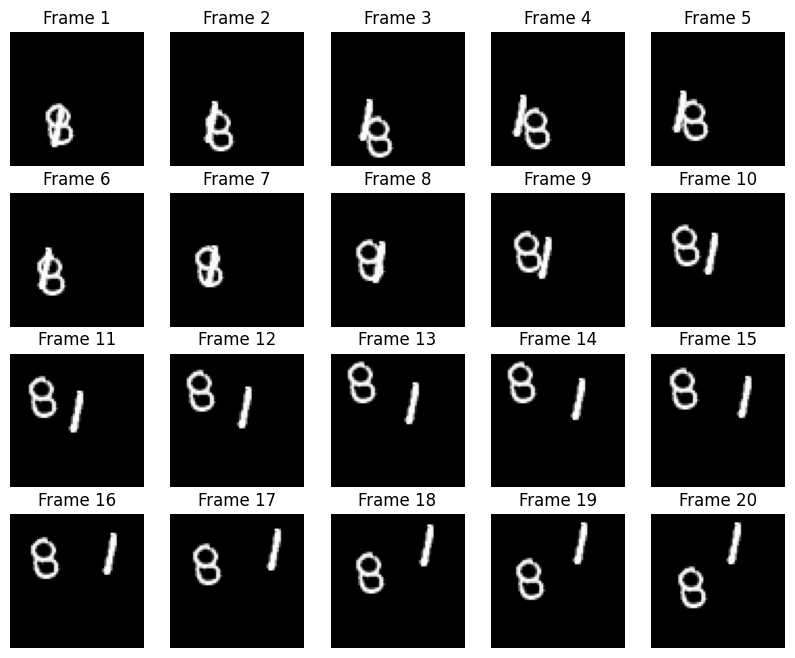

In [6]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    if idx < train_dataset.shape[1]:
        ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.axis("off")
    else:
        ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()


To see what a random sample looks like, run the following code-block:

In [19]:
num_steps = 3
num_samples = 1


## 2.2 Create DataLoader

The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size ``batch_size``.

In [20]:
batch_size = 1 # only one sample to learn
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True)

In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 1 # only one sample to learn
train_tensor = torch.tensor(train_dataset)
dataloader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, drop_last=True)


# 3. Construct Model

Let us try a simple network using only leaky integrate-and-fire layers without recurrence.
Subsequent tutorials will show how to use more complex neuron types with higher-order recurrence.
These architectures should work just fine, if there is no strong time dependency in the data, i.e., the next time step has weak dependence on the previous one.

A few notes on the architecture below:

* Setting `learn_beta=True` enables the decay rate `beta` to be a learnable parameter
* Each neuron has a unique, and randomly initialized threshold and decay rate
* The output layer has the reset mechanism disabled by setting `reset_mechanism="none"` as we will not use any output spikes

In [22]:
class Net(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps):
        super().__init__()

        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # layer 1
        self.fc_in = torch.nn.Linear(in_features=64*64, out_features=64*64)
        self.lif_in = snn.Leaky(beta=torch.rand(64*64), threshold=torch.rand(64*64), learn_beta=True, spike_grad=spike_grad)

        # layer 2
        self.fc_hidden = torch.nn.Linear(in_features=64*64, out_features=64*64)
        self.lif_hidden = snn.Leaky(beta=torch.rand(64*64), threshold=torch.rand(64*64), learn_beta=True, spike_grad=spike_grad)

        # layer 3
        self.fc_out = torch.nn.Linear(in_features=64*64, out_features=64*64)
        self.li_out = snn.Leaky(beta=torch.rand(64*64), threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none")

    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem_1 = self.lif_in.init_leaky()
        mem_2 = self.lif_hidden.init_leaky()
        mem_3 = self.li_out.init_leaky()

        # Empty lists to record outputs
        mem_3_rec = []

        # Loop over
        for step in range(self.timesteps):
            x_timestep = x[step, :, :]

            cur_in = self.fc_in(x_timestep.view(-1, 64*64))
            spk_in, mem_1 = self.lif_in(cur_in, mem_1)

            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_2 = self.lif_hidden(cur_hidden, mem_2)

            cur_out = self.fc_out(spk_hidden)
            _, mem_3 = self.li_out(cur_out, mem_3)

            mem_3_rec.append(mem_3)

        return torch.stack(mem_3_rec)


Instantiate the network below:

In [23]:
#hidden = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = Net(timesteps=num_steps).to(device)

Let's observe the behavior of the output neuron before it has been trained and how it compares to the target function:

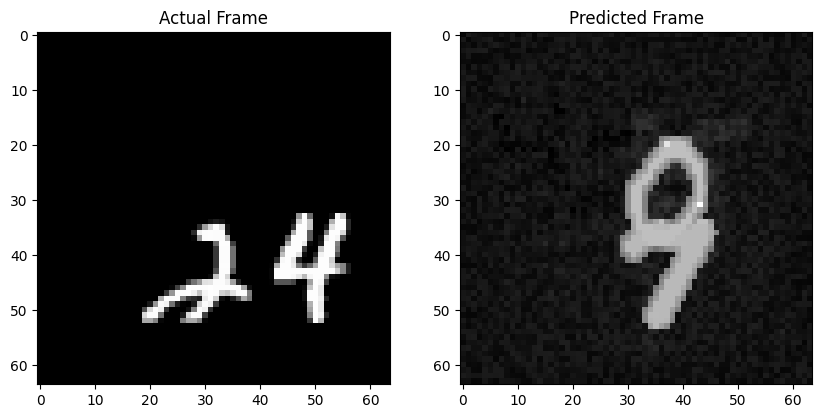

In [88]:
train_batch = iter(dataloader)

# run a single forward-pass
with torch.no_grad():
    for data in train_batch:
        data = data[0].to(device).float().transpose(0, 1)  # Transpose the tensor
        mem = model(data)

# transform mem to the desired shape
mem = mem.view(-1, 64, 64)

# plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(data[3, 0, :, :, 0].cpu().numpy(), cmap='gray')
plt.title("Actual Frame")

plt.subplot(1, 2, 2)
plt.imshow(mem[2, :, :].cpu().numpy(), cmap='gray')
plt.title("Predicted Frame")

plt.show()


Text(0.5, 1.0, 'Actual Frame')

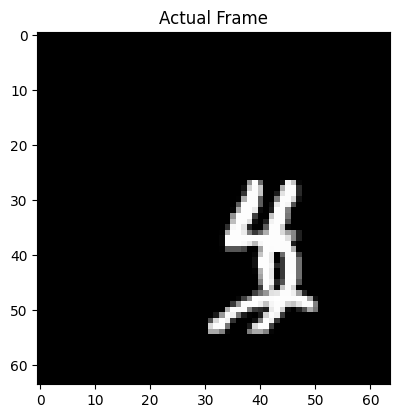

In [27]:
# plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(data[7, 0, :, :, 0].cpu().numpy(), cmap='gray')
plt.title("Actual Frame")

In [ ]:
data.size()

torch.Size([20, 1, 64, 64, 1])

In [ ]:
print(mem)

tensor([[[ 0.3270,  0.0639, -0.0831,  ...,  0.0646,  0.0658, -0.1234]],

        [[ 0.1871,  0.0683, -0.2794,  ...,  0.2111,  0.1495, -0.1022]],

        [[ 0.1725,  0.0916, -0.0638,  ...,  0.3167,  0.0457,  0.0625]],

        ...,

        [[ 0.0726, -0.0156, -0.4912,  ...,  0.2253,  0.2345,  0.2882]],

        [[ 0.1097,  0.0453, -0.5138,  ...,  0.2931,  0.4494,  0.3901]],

        [[ 0.2293,  0.0261, -0.4061,  ...,  0.3426,  0.3794,  0.2887]]],
       device='cuda:0')


In [31]:
num_iter = 2000 # train for 100 iterations
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_function = torch.nn.BCELoss()

loss_hist = [] # record loss

# select one random sample from the training dataset
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
data = train_dataset[data_choice]

# convert the data to a tensor
data = torch.tensor(data[0:3,:,:,:]).unsqueeze(0).to(device).transpose(0, 1).float()
data.size()

torch.Size([3, 1, 64, 64, 1])

In [90]:
num_iter = 2000 # train for 100 iterations
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_function = torch.nn.BCELoss()

loss_hist = [] # record loss

# select one random sample from the training dataset
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
data = train_dataset[data_choice]

data1 = torch.tensor(data).unsqueeze(0).to(device).transpose(0, 1).float()
# convert the data to a tensor
data = torch.tensor(data[0:4,:,:,:]).unsqueeze(0).to(device).transpose(0, 1).float()

# training loop
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        # forward pass
        mem = model(data[0:3,:,:,:])

        # calculate loss
        optimizer.zero_grad() # zero out gradients
        total_loss = 0

        loss_val = loss_function(torch.sigmoid(mem[2, :, :].view(1, 64*64)), data[3, 0, :, :, 0].view(1, 64*64)) # calculate loss
        total_loss += loss_val
        total_loss.backward() # calculate gradients
        optimizer.step() # update weights

        # store loss
        loss_hist.append(total_loss.item())

        avg_batch_loss = total_loss.item() # calculate average loss p/epoch
        pbar.set_postfix(loss="%.3e" % avg_batch_loss) # print loss p/batch


100%|██████████| 2000/2000 [01:11<00:00, 27.96it/s, loss=2.935e-02]


As the network has not yet been trained, it is unsurprising the membrane potential follows a senseless evolution.

# 4. Construct Training Loop

We call `torch.nn.MSELoss()` to minimize the mean square error between the membrane potential and the target evolution.

We iterate over the same sample of data.

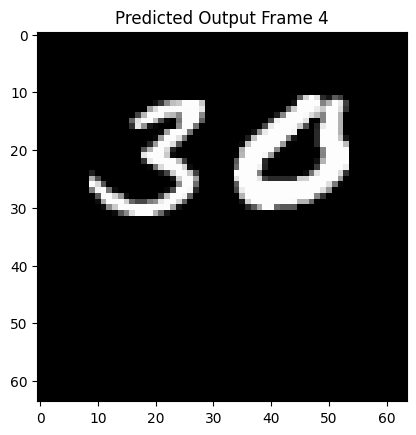

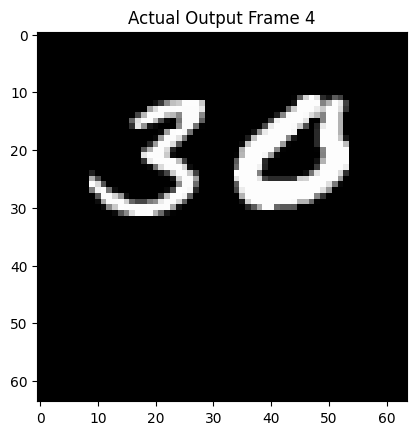

torch.Size([3, 1, 4096])


In [91]:

mem = model(data[0:3,:,:,:])
predicted_output = torch.sigmoid(mem[2, :, :].view(64, 64))
actual_output = data[3, 0, :, :, 0].view(64, 64)
plt.imshow(predicted_output.detach().cpu().numpy(), cmap='gray')
plt.title("Predicted Output Frame 4")
plt.show()
plt.imshow(actual_output.detach().cpu().numpy(), cmap='gray')
plt.title("Actual Output Frame 4")
plt.show()
print(mem.size())


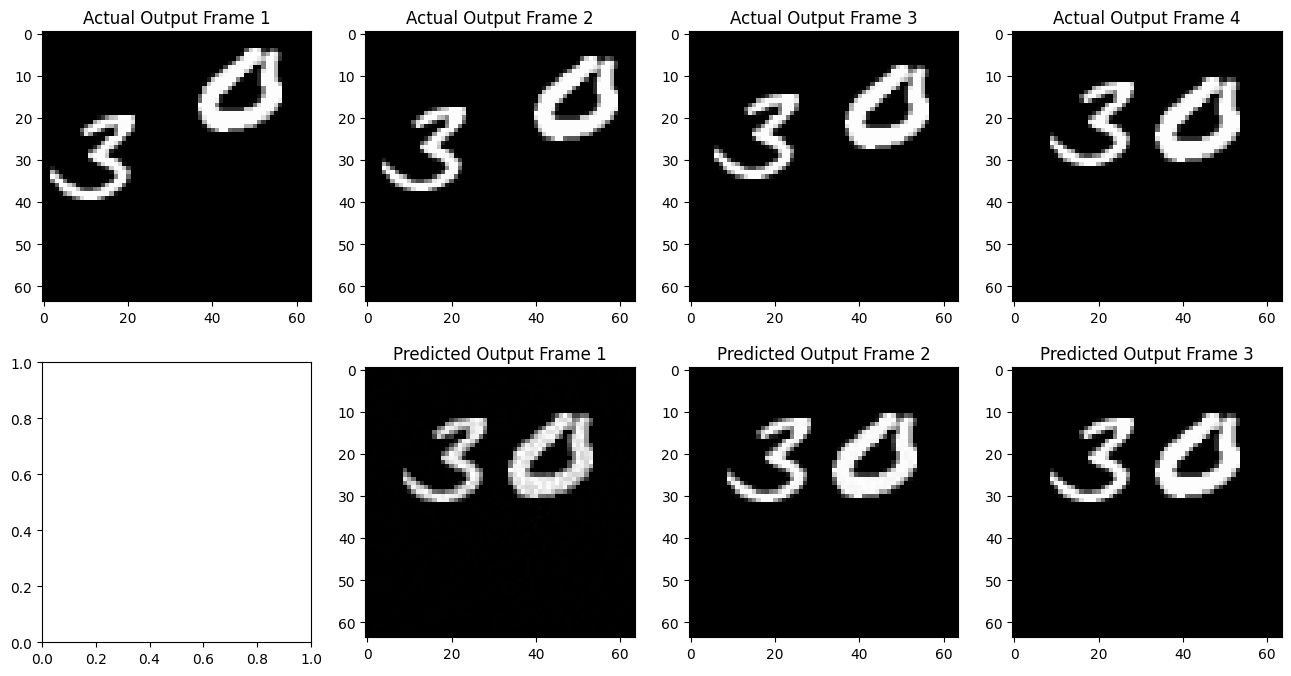

In [96]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    axs[0, i].imshow(data[i, 0, :, :, 0].detach().cpu().numpy(), cmap='gray')
    axs[0, i].set_title("Actual Output Frame {}".format(i+1))

predicted_output1 = torch.sigmoid(mem[0, :, :].view(64, 64))
predicted_output2 = torch.sigmoid(mem[1, :, :].view(64, 64))
predicted_output3 = torch.sigmoid(mem[2, :, :].view(64, 64))

axs[1, 1].imshow(predicted_output1.detach().cpu().numpy(), cmap='gray')
axs[1, 1].set_title("Predicted Output Frame 1")
axs[1, 2].imshow(predicted_output2.detach().cpu().numpy(), cmap='gray')
axs[1, 2].set_title("Predicted Output Frame 2")
axs[1, 3].imshow(predicted_output3.detach().cpu().numpy(), cmap='gray')
axs[1, 3].set_title("Predicted Output Frame 3")

plt.show()


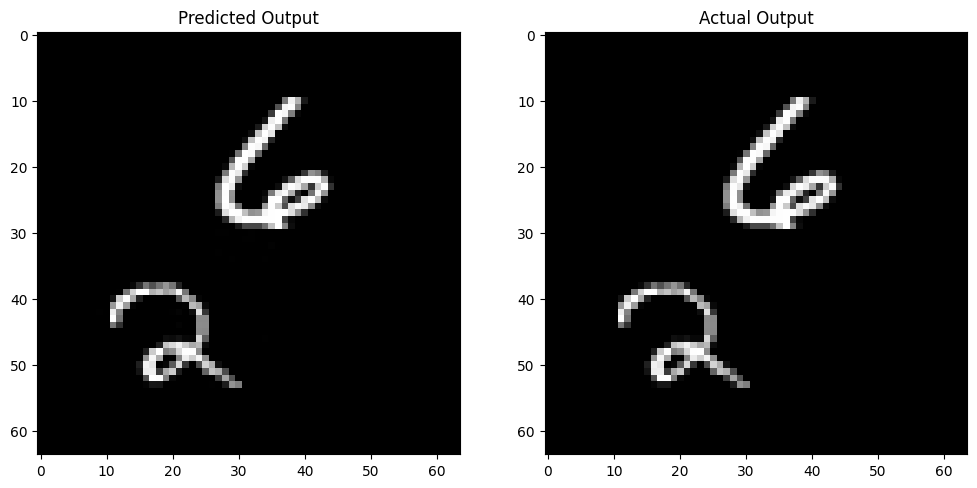

In [16]:
# Test the model
data = torch.tensor(train_dataset[data_choice]).unsqueeze(0).to(device).transpose(0, 1).float()
mem = model(data)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Initialize the plots
axs[0].imshow(torch.sigmoid(mem[0, :, :]).view(64, 64).detach().cpu().numpy(), cmap='gray')
axs[0].set_title("Predicted Output")

axs[1].imshow(data[0, 0, :, :, 0].detach().cpu().numpy(), cmap='gray')
axs[1].set_title("Actual Output")

# Animation function
def animate(i):
    axs[0].clear()
    axs[0].imshow(torch.sigmoid(mem[i, :, :]).view(64, 64).detach().cpu().numpy(), cmap='gray')
    axs[0].set_title("Predicted Output")

    axs[1].clear()
    axs[1].imshow(data[i, 0, :, :, 0].detach().cpu().numpy(), cmap='gray')
    axs[1].set_title("Actual Output")

# Create the animation
import matplotlib.animation as animation
ani = animation.FuncAnimation(fig, animate, frames=len(mem), interval=100)
ani.save('animation.mp4')


# 5. Evaluation

It is a little jagged, but it's not looking too bad.

You might try to improve the curve fit by expanding the size of the hidden layer, increasing the number of iterations, adding extra time steps, hyperparameter fine-tuning, or using a completely different neuron type.

# Conclusion

The next regression tutorials will test more powerful spiking neurons, such as Recurrent LIF neurons and spiking LSTMs, to see how they compare.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.


# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* More detail on nonlinear regression with SNNs can be found in our corresponding preprint here: [Henkes, A.; Eshraghian, J. K.; and Wessels, H.  “Spiking neural networks for nonlinear regression", arXiv preprint arXiv:2210.03515, Oct. 2022.](https://arxiv.org/abs/2210.03515)